# Preparing Dataset

## Download Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/"

In [4]:
!kaggle datasets download bryanb/abstract-art-gallery

 98% 680M/693M [00:08<00:00, 125MB/s] 
100% 693M/693M [00:08<00:00, 81.9MB/s]


## Unzip Dataset

In [5]:
!unzip abstract-art-gallery.zip

Archive:  abstract-art-gallery.zip
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_0.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_10.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_100.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1000.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1001.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1002.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1003.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1004.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1005.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1006.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1007.jpg  
  inflating: Abstract_gallery/Abstract_gallery/Abstract_image_1008.jpg  
  inflating: Abstract_gal

**rename folder**

In [6]:
%mv Abstract_gallery/Abstract_gallery Abstract_gallery/1

**import**

In [7]:
from tensorflow import keras
from keras.layers import Resizing,Conv2D,Conv2DTranspose,Dropout,Dense,Flatten,Activation
from keras.layers import GaussianNoise,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf

# Train Dataset Dataloader

In [8]:
train_ds = keras.utils.image_dataset_from_directory(
                                                    directory='Abstract_gallery/',
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    image_size=(64, 64),
                                                    batch_size=64)

Found 2782 files belonging to 1 classes.


**Scaling the Dataset**

Map to -1 to 1 (tanh activation)

In [9]:
train_ds = train_ds.map(lambda x, _: x/127.5 - 1.0)

# Create Generator Model

In [10]:
noise_shape = 100

In [ ]:
generator = Sequential()

generator.add(Dense(4*4*1024, input_shape=[noise_shape]))
generator.add(Activation('relu'))
generator.add(BatchNormalization())
generator.add(Reshape([4,4,1024]))

generator.add(Conv2DTranspose(512, kernel_size=5, strides=2, padding="same"))
generator.add(Activation('relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding="same"))
generator.add(Activation('relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"))
generator.add(Activation('relu'))
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding="same",
                                 activation='tanh'))


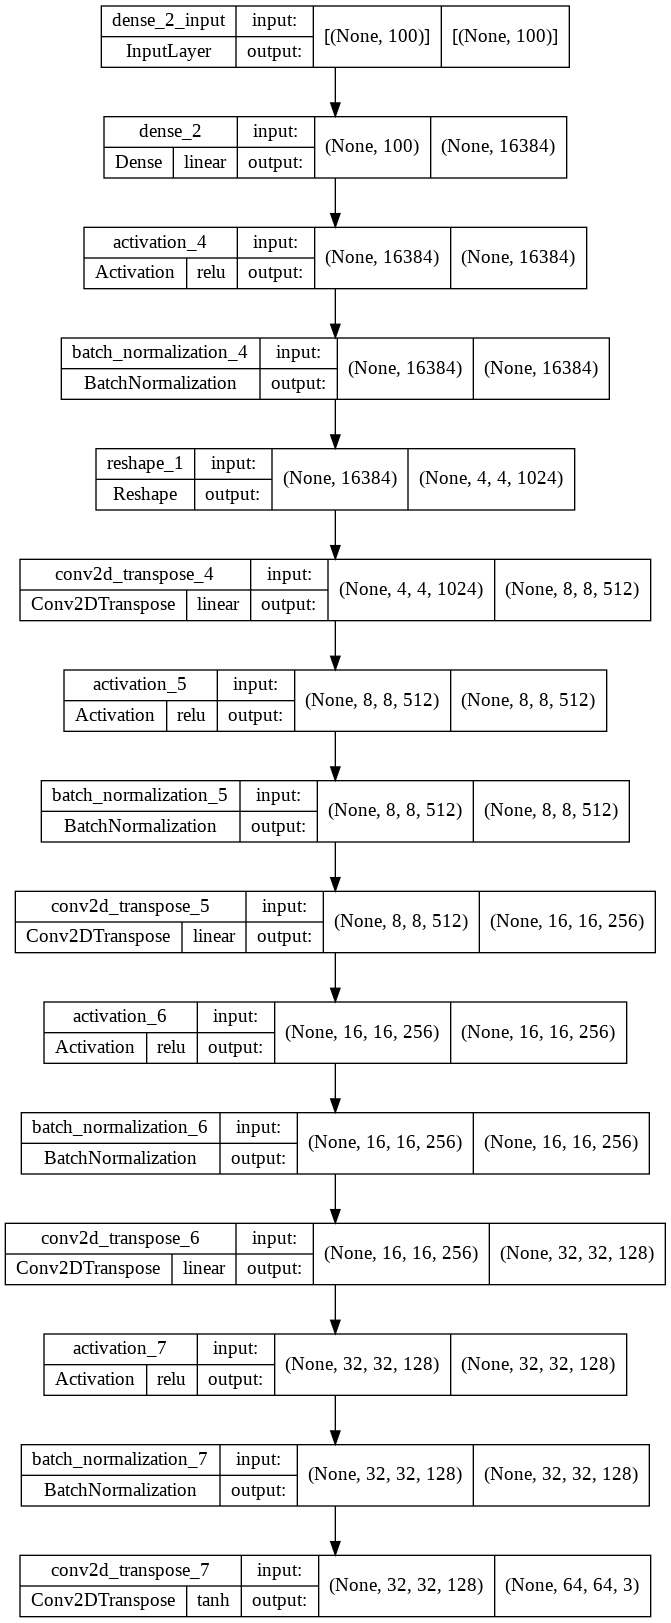

In [ ]:
plot_model(generator, show_shapes=True, show_layer_activations=True)

# Create Discriminator Model (For training D)

In [ ]:
discriminator = Sequential()

discriminator.add(GaussianNoise(0.02, input_shape=[64,64,3]))
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding="same"))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Flatten())
discriminator.add(Dense(1))

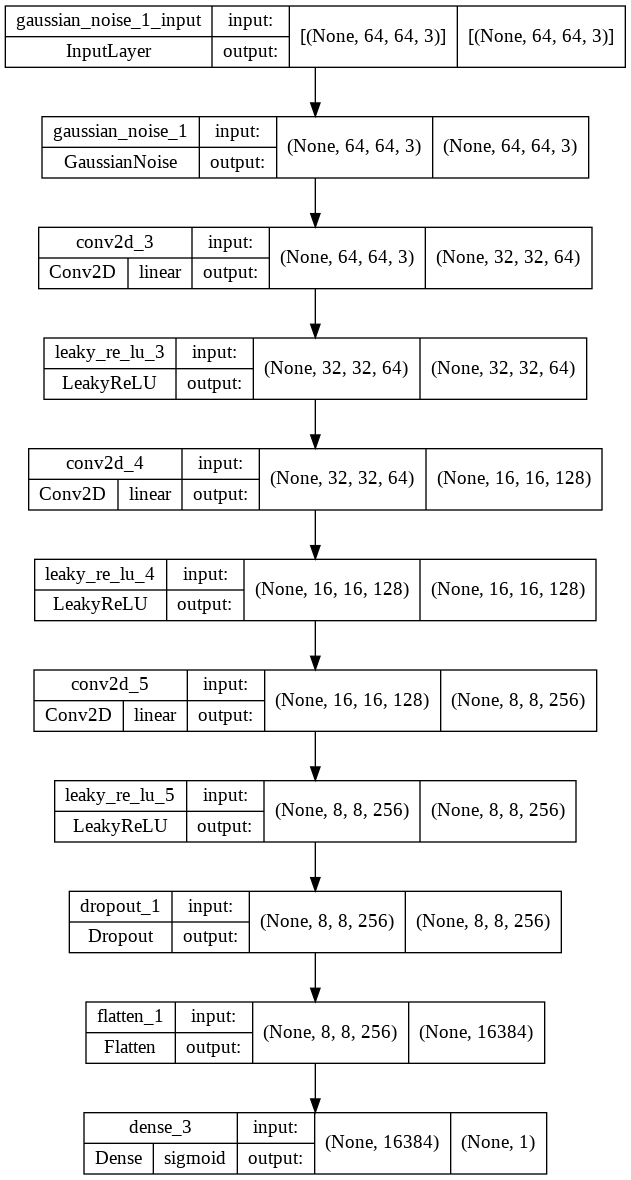

In [ ]:
plot_model(discriminator, show_shapes=True, show_layer_activations=True)

In [16]:
def show_5_images():
  z = tf.random.normal(shape=[5, 100])
  Gz = generator.predict(z)
  out = (Gz+1)*127.5
  out = out.astype('int32')
  fig = plt.figure(figsize=(20,4))
  for i in range(5):
    fig.add_subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(out[i], aspect='auto')
  plt.show()

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

wgan = WGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=noise_shape,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)
wgan.fit(train_ds, batch_size=64, epochs=100)

Epoch 1/100
44/44 [==============================] - 31s 530ms/step - d_loss: -5.0180 - g_loss: -41.3925
Epoch 2/100
44/44 [==============================] - 25s 539ms/step - d_loss: -5.3223 - g_loss: -33.8235
Epoch 3/100
44/44 [==============================] - 26s 549ms/step - d_loss: -5.4411 - g_loss: -36.2337
Epoch 4/100
44/44 [==============================] - 26s 553ms/step - d_loss: -5.5316 - g_loss: -30.1745
Epoch 5/100
44/44 [==============================] - 26s 548ms/step - d_loss: -5.1737 - g_loss: -42.7626
Epoch 6/100
44/44 [==============================] - 26s 558ms/step - d_loss: -5.7522 - g_loss: -38.7044
Epoch 7/100
44/44 [==============================] - 26s 551ms/step - d_loss: -5.1643 - g_loss: -29.7548
Epoch 8/100
44/44 [==============================] - 26s 556ms/step - d_loss: -5.1027 - g_loss: -37.9148
Epoch 9/100
44/44 [==============================] - 26s 549ms/step - d_loss: -4.7255 - g_loss: -28.8551
Epoch 10/100
44/44 [==============================] - 2

In [ ]:
generator.save('drive/MyDrive/generator_wasserstein.hdf5')
discriminator.save('drive/MyDrive/discriminator_wasserstein.hdf5')

In [11]:
from keras.models import load_model
generator = load_model('drive/MyDrive/generator_wasserstein.hdf5')

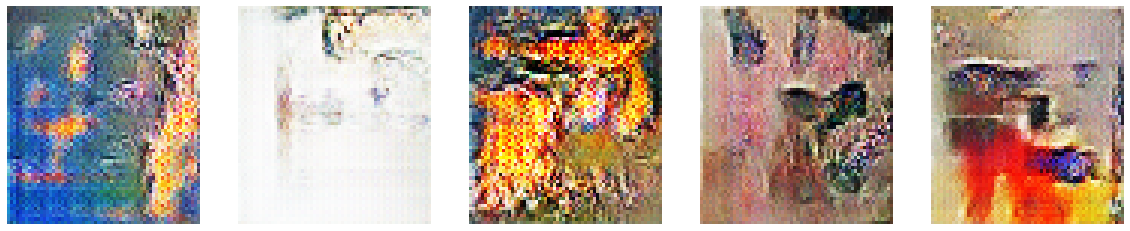

In [ ]:
show_5_images()

In [16]:
z = tf.random.normal(shape=[30, 100])
Gz = generator.predict(z)
out = (Gz+1)*127.5
out = out.astype('int32')

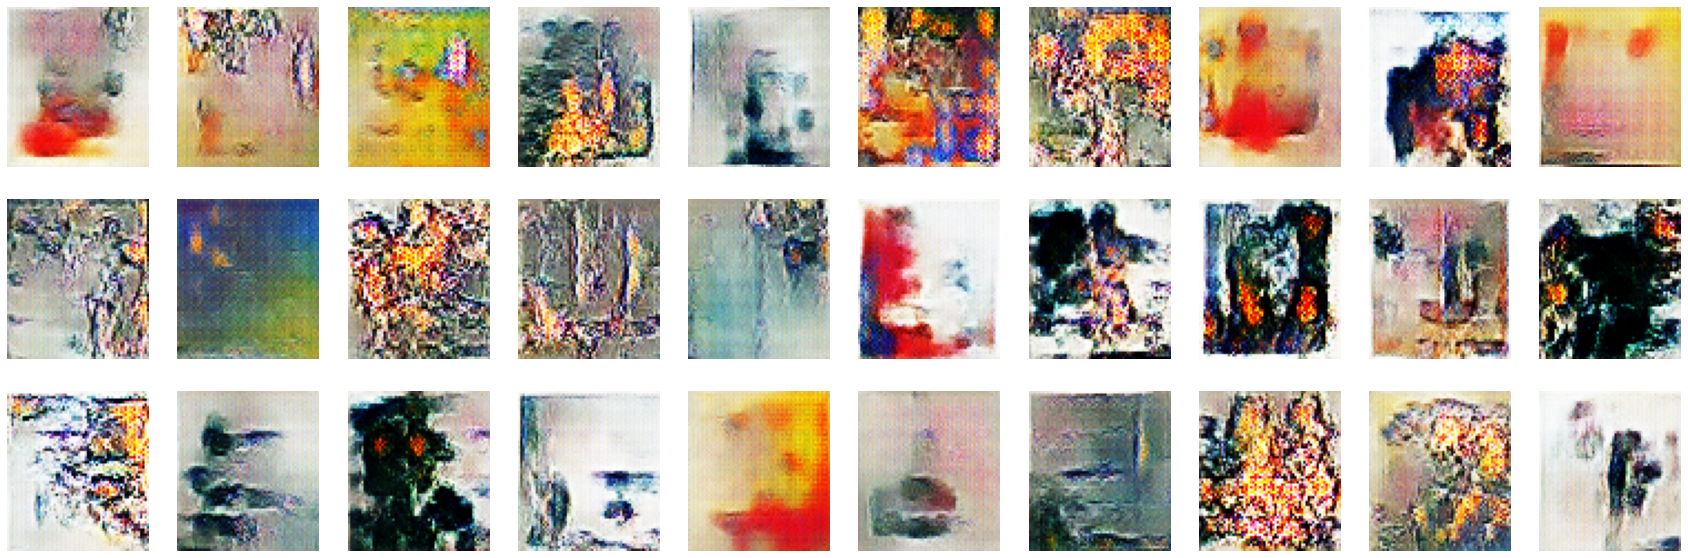

In [21]:
fig = plt.figure(figsize=(30,10))
for i in range(30):
  fig.add_subplot(3,10,i+1)
  plt.axis('off')
  plt.imshow(out[i], aspect='auto')
plt.show()